In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from skimage.io import imread
from argparse import Namespace
from tqdm import tqdm_notebook

In [2]:
dataset_dir = '/home/kirill/habitat-lab/data/datasets/opr_training_data/gibson'
subdir = 0

In [3]:
def get_point_cloud_from_z(Y, camera_matrix, scale=1):
    """Projects the depth image Y into a 3D point cloud.
    Inputs:
        Y is ...xHxW
        camera_matrix
    Outputs:
        X is positive going right
        Y is positive into the image
        Z is positive up in the image
        XYZ is ...xHxWx3
    """
    x, z = np.meshgrid(np.arange(Y.shape[-1]),
                       np.arange(Y.shape[-2] - 1, -1, -1))
    for i in range(Y.ndim - 2):
        x = np.expand_dims(x, axis=0)
        z = np.expand_dims(z, axis=0)
    X = (x[..., ::scale, ::scale] - camera_matrix.xc) * Y[..., ::scale, ::scale] / camera_matrix.f
    Z = (z[..., ::scale, ::scale] - camera_matrix.zc) * Y[..., ::scale, ::scale] / camera_matrix.f
    XYZ = np.concatenate((X[..., np.newaxis], Y[..., ::scale, ::scale][..., np.newaxis],
                          Z[..., np.newaxis]), axis=X.ndim)
    return XYZ

In [4]:
def get_camera_matrix(width, height, fov):
    """Returns a camera matrix from image size and fov."""
    xc = (width - 1.) / 2.
    zc = (height - 1.) / 2.
    f = (width / 2.) / np.tan(np.deg2rad(fov / 2.))
    camera_matrix = {'xc': xc, 'zc': zc, 'f': f}
    camera_matrix = Namespace(**camera_matrix)
    return camera_matrix

In [5]:
def voxel_filter(point_cloud, leaf_size, random=False):
    filtered_points = []
    # Calculate boundary points
    x_min, y_min, z_min = np.amin(point_cloud, axis=0) #Calculate the maximum value of the three dimensions of x y z
    x_max, y_max, z_max = np.amax(point_cloud, axis=0)
 
         # Calculate voxel grid dimension
    Dx = (x_max - x_min)//leaf_size + 1
    Dy = (y_max - y_min)//leaf_size + 1
    Dz = (z_max - z_min)//leaf_size + 1
    #print("Dx x Dy x Dz is {} x {} x {}".format(Dx, Dy, Dz))
 
    # Calculate the voxel index of each point
    h = list() #h is the list to save the index
    for i in range(len(point_cloud)):
        hx = (point_cloud[i][0] - x_min)//leaf_size
        hy = (point_cloud[i][1] - y_min)//leaf_size
        hz = (point_cloud[i][2] - z_min)//leaf_size
        h.append(hx + hy*Dx + hz*Dx*Dy)
    h = np.array(h)
 
    # Screening points
    h_indice = np.argsort(h) # Returns the index of the elements in h sorted from small to large
    h_sorted = h[h_indice]
    begin = 0
    for i in range(len(h_sorted)-1):   # 0~9999
        if h_sorted[i] == h_sorted[i + 1]:
            continue
        else:
            point_idx = h_indice[begin: i + 1]
            filtered_points.append(np.mean(point_cloud[point_idx], axis=0))
            begin = i
 
         # Change the point cloud format to array and return to the outside
    filtered_points = np.array(filtered_points, dtype=np.float64)
    return filtered_points

In [ ]:
camera_matrix = get_camera_matrix(1280, 720, 90)
for subdir in os.listdir(dataset_dir)[29:44]:
    poses = np.loadtxt(os.path.join(dataset_dir, str(subdir), 'poses.txt'))
    n = poses.shape[0] // 4
    for i in tqdm_notebook(range(n * 4)):
        rgb = imread(os.path.join(dataset_dir, subdir, '{}_rgb.png'.format(i + 1)))
        depth = imread(os.path.join(dataset_dir, subdir, '{}_depth.png'.format(i + 1)))
        depth = depth.astype(np.float32) / 255.
        depth = depth * 7.5 + 0.5
        #print(depth.min(), depth.max())
        pcd = get_point_cloud_from_z(depth, camera_matrix).reshape((-1, 3))
        pcd = voxel_filter(pcd, leaf_size=0.01)
        np.savez(os.path.join(dataset_dir, str(subdir), '{}_cloud.npz'.format(i + 1)), pcd)

/tmp/ipykernel_14224/2102202481.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n * 4)):


  0%|          | 0/96 [00:00<?, ?it/s]

In [17]:
os.listdir(dataset_dir).index(subdir)

86

In [14]:
pcd.shape

(8562, 3)

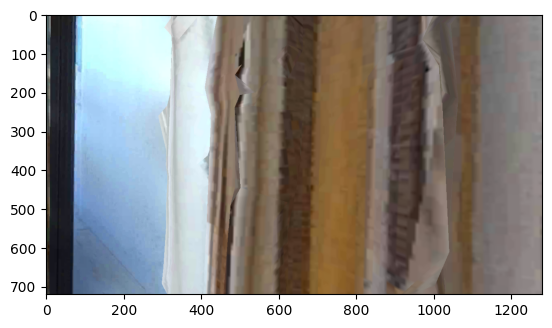

In [17]:
plt.imshow(rgb)

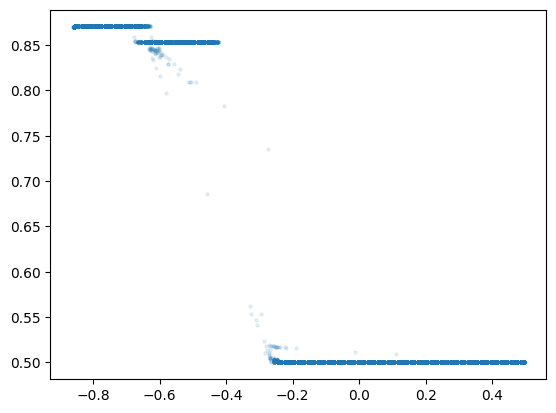

In [16]:
plt.scatter(pcd[:, 0], pcd[:, 1], alpha=0.1, s=5)